# Noise reduction using Machine learning

Here, I present a simple machine-learning algorithm, a denoising autoencoder, to reduce noise in the Green's function obtained from the quantum Monte Carlo method. The Quantum Monte Carlo method is a stochastic method, and, therefore, the results obtained will be noisy. To perform the analytic continuation, noise must be removed. Here, we use deep learning neural networks to remove noise from the Green's function.

## Overview

This notebook demonstrates the process of:
1. Loading noisy and clean synthetic Green's function data.
2. Preprocessing the data (splitting and scaling).
3. Defining and training a Denoising Autoencoder (DAE) using TensorFlow/Keras.
4. Evaluating the model's performance by plotting losses and comparing denoised signals to the original noisy and clean signals.

## Import the necessary modules

In [1]:
import pandas as pd
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
from sklearn.metrics import mean_squared_error 
from math import pi

2025-10-25 15:43:30.104100: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-10-25 15:43:30.139497: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX512F AVX512_VNNI, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Data Loading and Preparation

Load the synthetic Green's function data.
- `G_tau_n.csv`: Contains the noisy Green's function data ($G(\tau)$ with added noise). This will be the input (X) to the model.
- `G_tau.csv`: Contains the original clean Green's function data. This will be the target (y) the model learns to reconstruct.

The data is expected to be in CSV format where each *row* represents a different $\tau$ point and each *column* represents a different sample. We transpose it (`.T`) so that each row is a sample.

**Note:** Ensure the CSV files are located in the specified directory relative to the notebook (e.g., a folder named `5e-2/`). The total number of samples is 200,000.

In [2]:
df_Gtau_noise = pd.read_csv('5e-2/G_tau_n.csv').T
df_Gtau = pd.read_csv('5e-2/G_tau.csv').T
X=df_Gtau_noise.values[:,:]
y=df_Gtau.values[:,:]
X = np.expand_dims(X, axis=-1)

### Train/Validation/Test Split

In [3]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y,test_size=0.25, random_state=42, shuffle=True)
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=2/3, random_state=42, shuffle=True)
print("Shapes:")
print("Train:", X_train.shape, y_train.shape)
print("Valid:", X_valid.shape, y_valid.shape)
print("Test:",  X_test.shape, y_test.shape)

Shapes:
Train: (150000, 300, 1) (150000, 300)
Valid: (16666, 300, 1) (16666, 300)
Test: (33334, 300, 1) (33334, 300)


Rescaling the input data to feed it to the machine learning model.

### Data Scaling
Scale the input features (X) and target values (y) using `StandardScaler`. Scaling helps the neural network train more effectively.

In [4]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.reshape(-1, X_train.shape[1])).reshape(X_train.shape)
X_valid_scaled = scaler.transform(X_valid.reshape(-1, X_valid.shape[1])).reshape(X_valid.shape)
X_test_scaled = scaler.transform(X_test.reshape(-1, X_test.shape[1])).reshape(X_test.shape)
y_scaler = StandardScaler()
y_train_scaled = y_scaler.fit_transform(y_train.reshape(-1, y_train.shape[1])).reshape(y_train.shape)
y_valid_scaled = y_scaler.transform(y_valid.reshape(-1, y_valid.shape[1])).reshape(y_valid.shape)


## Denoising Autoencoder (DAE) Model

In [5]:
class DenoisingAutoencoder(keras.Model):
    def __init__(self, input_shape_tuple, **kwargs):
        super().__init__(**kwargs)
        self.input_dim = input_shape_tuple[0]
        l2 = 1e-4
        reg = keras.regularizers.l2(l2)

        # Encoder layer
        
        self.conv1 = layers.Conv1D(16, 5, padding="same", activation="relu", kernel_regularizer=reg)
        self.bn1 = layers.BatchNormalization()
        self.pool1 = layers.MaxPooling1D(2,padding="same")
        self.dropout1 = layers.Dropout(0.2)
        
        self.conv2 = layers.Conv1D(32, 5, padding="same", activation="relu", kernel_regularizer=reg)
        self.bn2 = layers.BatchNormalization()
        self.pool2 = layers.MaxPooling1D(2,padding="same")
        self.dropout2 = layers.Dropout(0.2)

        # Bottleneck layer
        
        self.conv3 = layers.Conv1D(64, 5, padding="same", activation="relu", kernel_regularizer=reg)
        self.bn3 = layers.BatchNormalization()
        self.dropout3 = layers.Dropout(0.2)  
        
        self.upsample1 = layers.UpSampling1D(2)
        self.conv4 = layers.Conv1D(32, 5, padding="same", activation="relu", kernel_regularizer=reg)
        self.bn4 = layers.BatchNormalization()
        self.dropout4 = layers.Dropout(0.2)  
        
        self.upsample2 = layers.UpSampling1D(2)
        self.conv5 = layers.Conv1D(16, 5, padding="same", activation="relu", kernel_regularizer=reg)
        self.bn5 = layers.BatchNormalization()
        self.dropout5 = layers.Dropout(0.2)
        
        self.output_conv = layers.Conv1D(1, 5, padding="same", activation="linear", kernel_regularizer=reg)

    def call(self, inputs, training=False):

        x = self.conv1(inputs)
        x = self.bn1(x, training=training)
        x = self.pool1(x)
        x = self.dropout1(x, training=training)
        
        x = self.conv2(x)
        x = self.bn2(x, training=training)
        x = self.pool2(x)
        x = self.dropout2(x, training=training)
        
        x = self.conv3(x)
        x = self.bn3(x, training=training)
        x = self.dropout3(x, training=training)

        x = self.upsample1(x)
        x = self.conv4(x)
        x = self.bn4(x, training=training)
        x = self.dropout4(x, training=training)
        
        x = self.upsample2(x)
        x = self.conv5(x)
        x = self.bn5(x, training=training)
        x = self.dropout5(x, training=training)

        return self.output_conv(x)

INPUT_SHAPE_TUPLE = X_train.shape[1:]  

optimizer = keras.optimizers.Adam(learning_rate=1e-4, weight_decay=1e-5)

callbacks = [
    keras.callbacks.EarlyStopping(
        monitor='val_loss', 
        patience=20, 
        restore_best_weights=True,
        min_delta=0.0001 
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss', 
        factor=0.4, 
        patience=8,  
        min_lr=1e-8
    ),
    keras.callbacks.ModelCheckpoint(
        'best_model.keras', 
        monitor='val_loss',
        save_best_only=True,
        mode='min'
    )
]


model = DenoisingAutoencoder(INPUT_SHAPE_TUPLE)

model.compile(optimizer=optimizer, loss='mae')

print("\n--- Model Summary ---")

EPOCHS = 100
BATCH_SIZE = 128

print("\n--- Starting Supervised Denoising Training ---")
history = model.fit(
    X_train_scaled, y_train_scaled, 
    epochs=EPOCHS, 
    batch_size=BATCH_SIZE, 
    shuffle=True, 
    validation_data=(X_valid_scaled, y_valid_scaled),
    callbacks=callbacks  
)

print("\n--- Denoising Test Data ---")
predicted_signal_scaled = model.predict(X_test_scaled)
predicted_signal = y_scaler.inverse_transform(
    predicted_signal_scaled.reshape(-1, predicted_signal_scaled.shape[1])
).reshape(predicted_signal_scaled.shape)


--- Model Summary ---

--- Starting Supervised Denoising Training ---
Epoch 1/100
   1/1172 ━━━━━━━━━━━━━━━━━━━━ 1:09:36 4s/step - loss: 1.3437

2025-10-25 15:46:41.667157: E tensorflow/core/util/util.cc:131] oneDNN supports DT_INT32 only on platforms with AVX-512. Falling back to the default Eigen-based implementation if present.


1172/1172 ━━━━━━━━━━━━━━━━━━━━ 38s 30ms/step - loss: 0.4835 - val_loss: 0.2353 - learning_rate: 1.0000e-04
Epoch 2/100
1172/1172 ━━━━━━━━━━━━━━━━━━━━ 32s 27ms/step - loss: 0.3155 - val_loss: 0.2486 - learning_rate: 1.0000e-04
Epoch 3/100
1172/1172 ━━━━━━━━━━━━━━━━━━━━ 32s 28ms/step - loss: 0.2750 - val_loss: 0.2208 - learning_rate: 1.0000e-04
Epoch 4/100
1172/1172 ━━━━━━━━━━━━━━━━━━━━ 32s 27ms/step - loss: 0.2611 - val_loss: 0.2313 - learning_rate: 1.0000e-04
Epoch 5/100
1172/1172 ━━━━━━━━━━━━━━━━━━━━ 32s 27ms/step - loss: 0.2528 - val_loss: 0.2262 - learning_rate: 1.0000e-04
Epoch 6/100
1172/1172 ━━━━━━━━━━━━━━━━━━━━ 32s 28ms/step - loss: 0.2461 - val_loss: 0.2195 - learning_rate: 1.0000e-04
Epoch 7/100
1172/1172 ━━━━━━━━━━━━━━━━━━━━ 33s 28ms/step - loss: 0.2412 - val_loss: 0.2177 - learning_rate: 1.0000e-04
Epoch 8/100
1172/1172 ━━━━━━━━━━━━━━━━━━━━ 32s 27ms/step - loss: 0.2378 - val_loss: 0.2074 - learning_rate: 1.0000e-04
Epoch 9/100
1172/1172 ━━━━━━━━━━━━━━━━━━━━ 32s 27ms/step - l

## Results (Noise = 5e-2)

Plotting the training and validation loss over epochs helps visualize the learning process and check for overfitting.


--- Plotting Training History ---


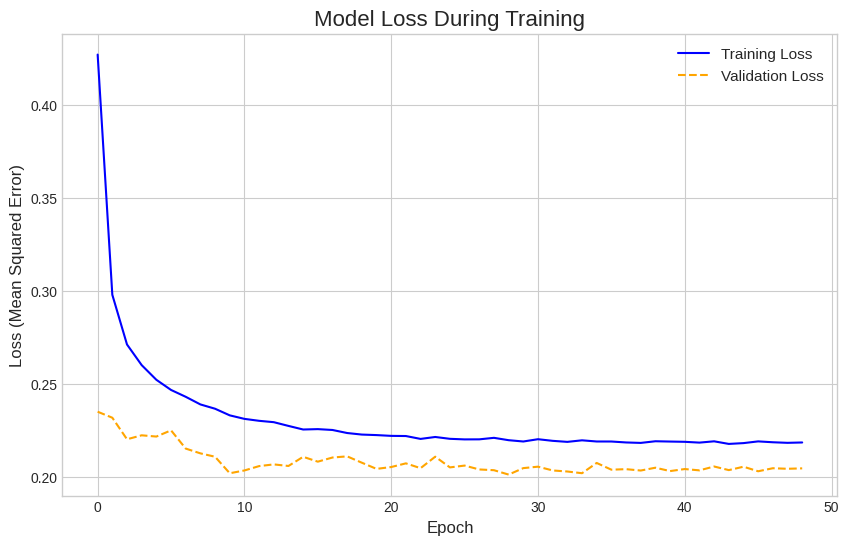

In [6]:
print("\n--- Plotting Training History ---")

plt.style.use('seaborn-v0_8-whitegrid')
plt.figure(figsize=(10, 6))

plt.plot(history.history['loss'], label='Training Loss', color='blue', linestyle='-')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange', linestyle='--')

plt.title('Model Loss During Training', fontsize=16)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss (Mean Squared Error)', fontsize=12)
plt.legend(fontsize=11)
plt.savefig("denoising_model(inp100_layer1024_512_256_128_128).png")
plt.show()


### Denoising Examples Plot

Visualize the denoising performance on a few random samples from the test set. 

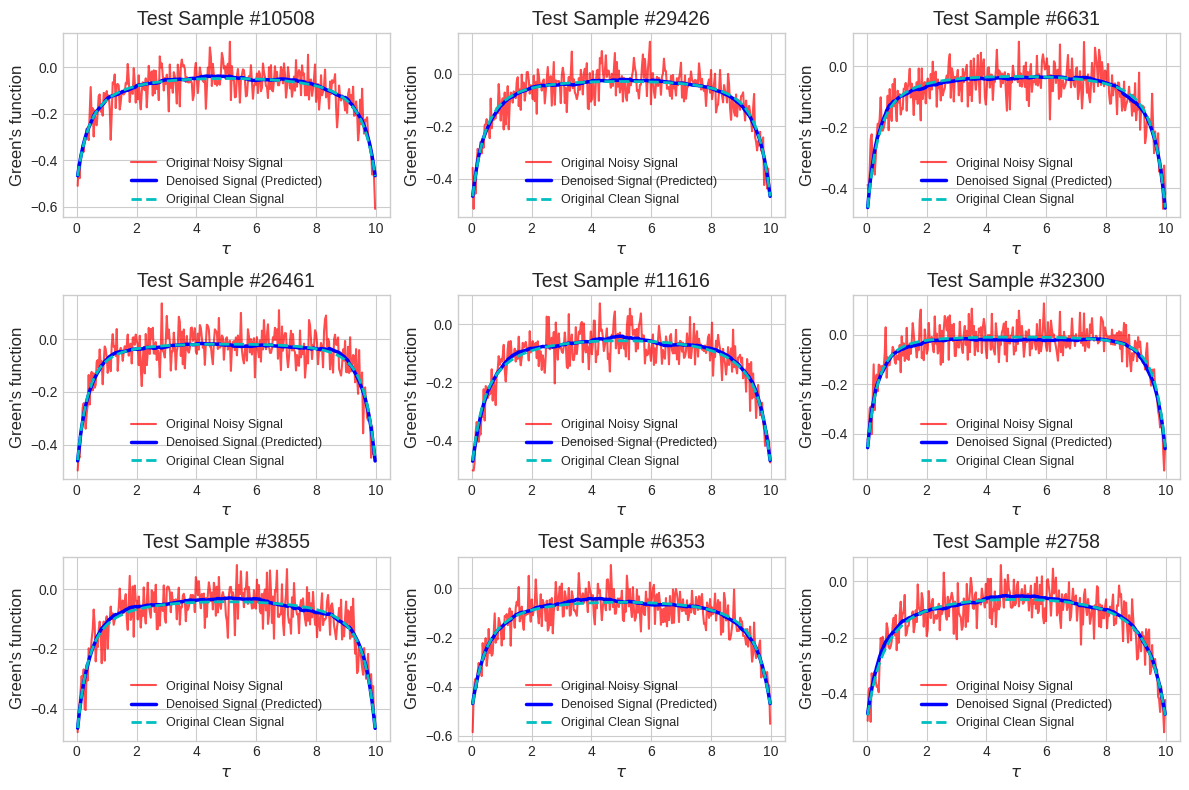

In [8]:
num_samples = 9
sample_indices = np.random.choice(X_test.shape[0], num_samples, replace=False)
plt.style.use('seaborn-v0_8-whitegrid')
fig, axes = plt.subplots(3, 3, figsize=(12, 8))
axes = axes.flatten()
beta=10.0
tau_list=np.linspace(0,beta,300)

for i, idx in enumerate(sample_indices):
    ax = axes[i]
    ax.plot(tau_list[1:-1],X_test[idx,1:-1], 'r-', label='Original Noisy Signal', alpha=0.7)
    ax.plot(tau_list[1:-1],predicted_signal[idx,1:-1], 'b-', label='Denoised Signal (Predicted)', linewidth=2.5)
    ax.plot(tau_list[1:-1],y_test[idx][1:-1], 'c--', label='Original Clean Signal', linewidth=2)
    ax.set_title(f'Test Sample #{idx}', fontsize=14)
    ax.set_xlabel(r'$\tau$', fontsize=12)
    ax.set_ylabel('Green\'s function', fontsize=12)
    ax.legend(fontsize=9)

plt.tight_layout()
plt.show()

## Results (Noise = 5e-3)

Plotting the training and validation loss over epochs.


--- Plotting Training History ---


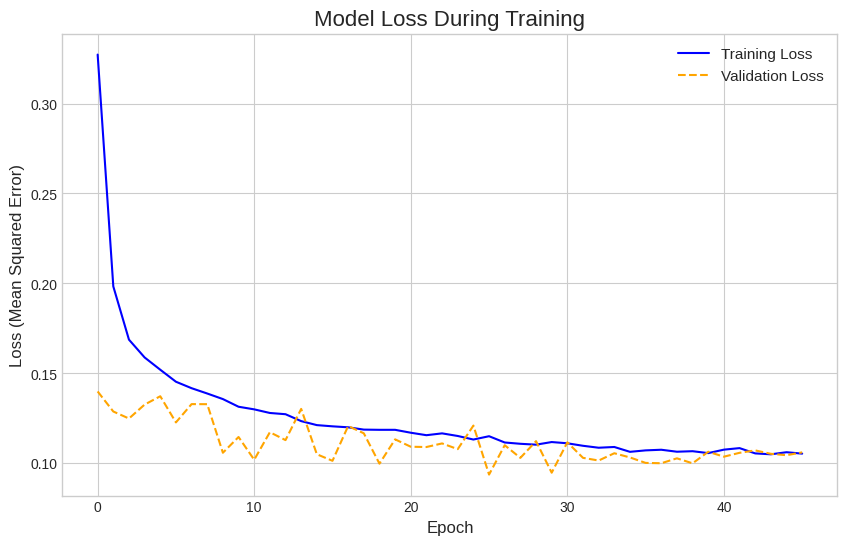

In [6]:
print("\n--- Plotting Training History ---")

plt.style.use('seaborn-v0_8-whitegrid')
plt.figure(figsize=(10, 6))

plt.plot(history.history['loss'], label='Training Loss', color='blue', linestyle='-')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange', linestyle='--')

plt.title('Model Loss During Training', fontsize=16)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss (Mean Squared Error)', fontsize=12)
plt.legend(fontsize=11)
plt.savefig("denoising_model(inp100_layer1024_512_256_128_128).png")
plt.show()


### Denoising Examples Plot

Visualize the denoising performance on a few random samples from the test set. 

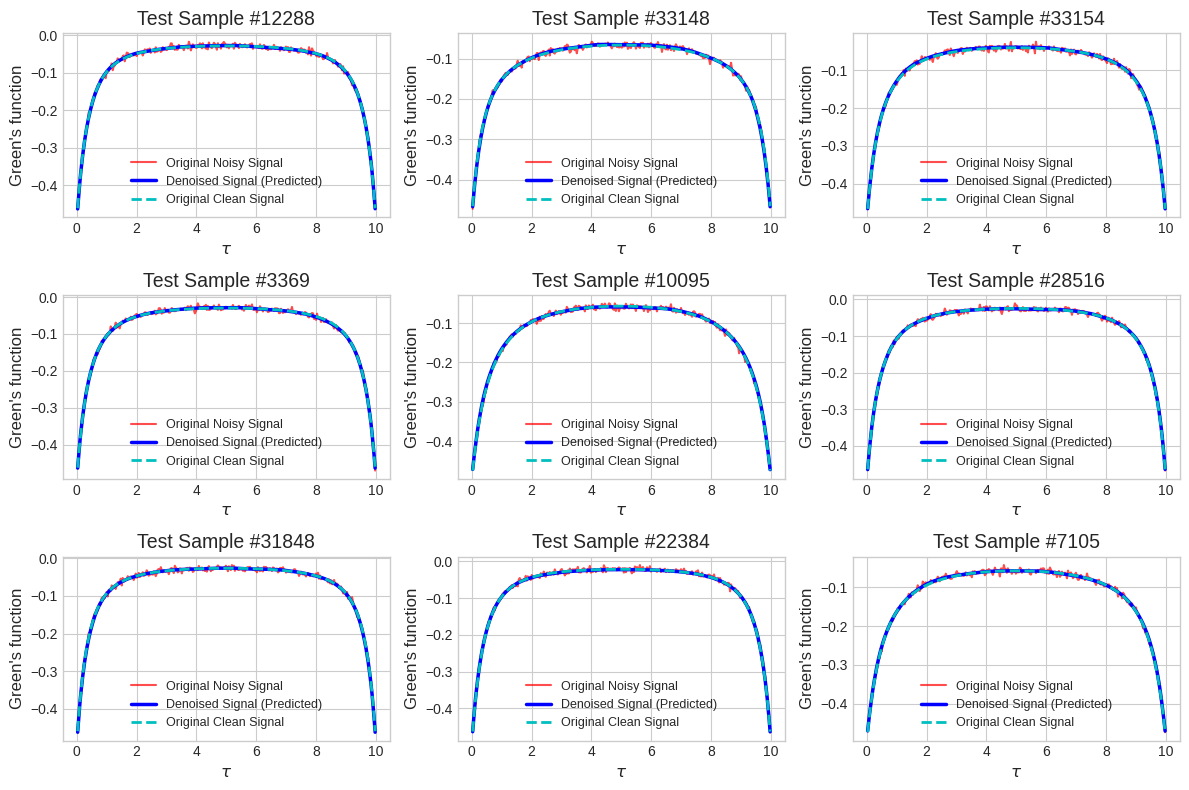

In [7]:
num_samples = 9
sample_indices = np.random.choice(X_test.shape[0], num_samples, replace=False)
plt.style.use('seaborn-v0_8-whitegrid')
fig, axes = plt.subplots(3, 3, figsize=(12, 8))
axes = axes.flatten()
beta=10.0
tau_list=np.linspace(0,beta,300)

for i, idx in enumerate(sample_indices):
    ax = axes[i]
    ax.plot(tau_list[1:-1],X_test[idx,1:-1], 'r-', label='Original Noisy Signal', alpha=0.7)
    ax.plot(tau_list[1:-1],predicted_signal[idx,1:-1], 'b-', label='Denoised Signal (Predicted)', linewidth=2.5)
    ax.plot(tau_list[1:-1],y_test[idx][1:-1], 'c--', label='Original Clean Signal', linewidth=2)
    ax.set_title(f'Test Sample #{idx}', fontsize=14)
    ax.set_xlabel(r'$\tau$', fontsize=12)
    ax.set_ylabel('Green\'s function', fontsize=12)
    ax.legend(fontsize=9)

plt.tight_layout()
plt.show()

## Summary

To summarize, the denoising autoencoder performs well in filtering the noise. Combining this approach with many-body techniques for analytic continuation should yield better results.